This notebook compares the QMLE performance on a masked signal (accounting for appropriate weights) vs an FFT estimator

In [1]:
import sys
sys.path.append('/nfs/pic.es/user/m/mlokken/Lya_Px/px-optimal-estimator/')
import numpy as np
import estimator as est
import os
from lace.cosmo import camb_cosmo
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
import forestflow
from scipy.interpolate import interp1d
%load_ext autoreload
%autoreload 2
sys.path.append('/nfs/pic.es/user/m/mlokken/p1d-px-fft-weight/')
import matplotlib.pyplot as plt
from hydrosim_skewers import bin_spectra
from contamination import SiliconModel, SpikeModel

Set the masking mode

In [2]:
mode = '2skyline'

Load the skewer data

In [3]:
skews = np.load("/data/desi/common/HydroData/Emulator/post_768/delta_x/central_with_silicon_spike/skewers_6_psim_plus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz")
delta_flux = skews['delta_flux_x']
xpar = skews['xpar']
L = skews['L_Mpc']
Np = delta_flux.shape[1]
pix_spacing = skews['los_spacing_Mpc']

In [4]:
delta_flux = skews['delta_flux_x']
xpar = skews['xpar']
L = skews['L_Mpc']
Np = delta_flux.shape[1]
pix_spacing = skews['los_spacing_Mpc']

Read the chosen mask

In [5]:
maskdir = "/data/desi/scratch/mlokken/masking/"
masks = []
masknames = []

masklist = ['random_mask.npy', 'skyline_mask.npy', 'double_skyline_mask.npy', 'dla_mask.npy', 'dla_small_mask.npy']
if mode=='random':
    index = 0
elif mode=='skyline':
    index = 1
elif mode=='2skyline':
    index = 2
elif mode=='dla_large':
    index = 3
elif mode=='dla_small':
    index = 4
        
if mode=='all':
    for maskfile in masklist:
        masks.append(np.load(maskdir+maskfile))
        # ((nside, nside, Np)) reshape
        masknames.append(os.path.splitext(maskfile)[0])
else:
    maskfile = masklist[index]
    masks.append(np.load(maskdir+maskfile))
    masknames.append(os.path.splitext(maskfile)[0])

Apply the mask

In [6]:
delta_flux_masked = delta_flux * masks[0]

Sub-sample to save memory and time, if desired

In [7]:
subsample = True
if subsample:
    subfac = 100
    delta_flux_masked = delta_flux_masked[::subfac].real
    delta_flux = delta_flux[::subfac].real
    mask = masks[0][::subfac]
    del masks
nskew = delta_flux.shape[0]

Bin to save memory and time

In [8]:
binning=True
if binning:
    # bin delta_flux along line-of-sight
    binsize = 5
    if Np%binsize != 0:
        print("Np is not divisible by binsize")
        sys.exit()
    delta_flux_masked, dnu = bin_spectra(delta_flux_masked, xpar, binsize)
    delta_flux, x = bin_spectra(delta_flux, xpar, binsize)
    Np=delta_flux.shape[1]
    print(f"Spacing between pixels along line-of-sight before binning = {pix_spacing} Mpc")
    mask, xpar = bin_spectra(mask, xpar, binsize) # rewrite both mask and xpar
    pix_spacing = xpar[1]-xpar[0]
    print(f"Spacing between pixels along line-of-sight before binning = {pix_spacing} Mpc")

Number of bins: 270
Number of bins: 270
Spacing between pixels along line-of-sight after binning = 0.05 Mpc
Number of bins: 270


In [9]:
snap_num = 6

In [10]:
# get the model

path_program = forestflow.__path__[0]

folder_lya_data = path_program[:-10]+ "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-10],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 
arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

In [11]:
# input the details into the ArinyoModel class

cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)

In [156]:
def s_fid_contam(arinyo, z, arinyo_params, delta_x_matrix, pix_width, Silicon, k_spike_range, plot=False):
    from scipy.interpolate import CubicSpline
    Nk_full = 100000
    kmax = 200
    kfine = np.linspace(0, kmax, Nk_full)
    kspike_fine = (kfine<k_spike_range[1])&(kfine>k_spike_range[0])
    pixwidth_arr = np.full(len(kfine), pix_width)

    p1d_fid_orig = arinyo.P1D_Mpc(z, kfine, parameters=arinyo_params)
    p1d_fid = np.copy(p1d_fid_orig)
    p1d_fid *= Silicon.power_contamination(kfine)
    # p1d_fid += Spike.power_contamination(kfine)
    p1d_fid[kspike_fine] += 0.5
    windowed_pk = p1d_fid*est.w_k(kfine, pixwidth_arr)**2
    
    # FFT to get the windowed correlation function
    kpar_range_full = np.linspace(0, kmax, Nk_full)
    kspacing_full = kmax / Nk_full
    windowed_xi = np.fft.irfft(windowed_pk) * Nk_full * kspacing_full / np.pi
    delta_x_spacing = np.pi / (kpar_range_full[-1] - kpar_range_full[0])
    Nx = 2 * (Nk_full - 1)
    x = np.arange(Nx) * delta_x_spacing
    if plot:
        plt.semilogx(kfine, windowed_pk, label='windowed theory')
        plt.semilogx(kfine, p1d_fid, label='non-windowed theory')
        plt.semilogx(kfine, p1d_fid_orig, label='uncontaminated theory')

        plt.legend()
        plt.show()
        plt.clf()
        
        plt.plot(x, np.fft.irfft(p1d_fid_orig) * Nk_full * kspacing_full / np.pi, label="Uncontaminated theory")

        plt.plot(x, np.fft.irfft(p1d_fid) * Nk_full * kspacing_full / np.pi, label="non-windowed theory")
        plt.plot(x, windowed_xi, label="windowed theory")
        plt.xlabel("x [Mpc]")
        plt.xlim([0,70])
        plt.ylabel("xi")
        plt.legend()
        plt.show()
        plt.clf()

    # make xi into a function
    xi_fid = CubicSpline(x, windowed_xi)
    # calculate the matrix
    s_fid = xi_fid(delta_x_matrix)
    return s_fid, xi_fid


In [98]:
km_spike = 0.46542113
k_spike_range = [km_spike-np.pi/L, km_spike+np.pi/L]

In [99]:
k_spike_range

[0.4188790166134846, 0.5119632433865154]

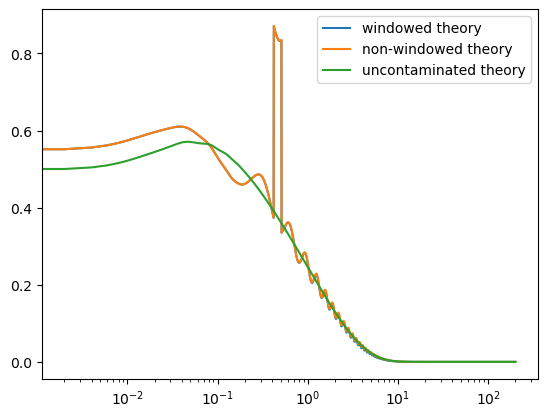

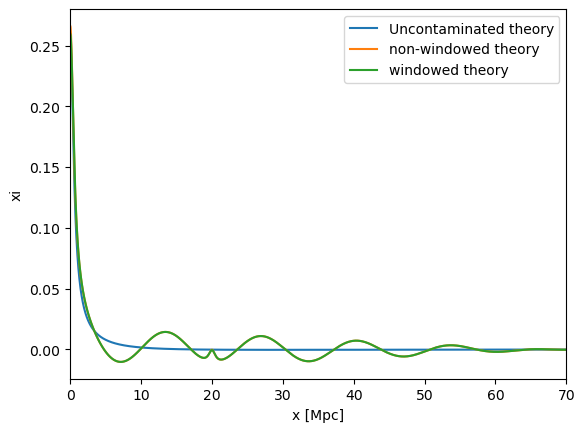

<Figure size 640x480 with 0 Axes>

In [157]:
# do the setup
delta_x_matrix = est.make_delta_x_matrix(L, Np, xpar)
Sil = SiliconModel()
# Spike = SpikeModel(a_spike=0.5, k_spike=.465)
# S_fiducial = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix, pix_spacing, plot=False)
# try adding contamination to S_fid
S_fiducial, xi_fid = s_fid_contam(arinyo, zs[0], arinyo_params, delta_x_matrix, pix_spacing, Sil, k_spike_range, plot=True)
# Leff=1000
# Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
# spacing_fine=Leff/Np_fine
# kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
# p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
# kspike_fine = (kfine<k_spike_range[1])&(kfine>k_spike_range[0])
# contaminated_p1d = p1d_fine * Sil.power_contamination(kfine)+ Spike.power_contamination(kfine)
# contaminated_p1d = p1d_fine * Sil.power_contamination(kfine)
# contaminated_p1d[kspike_fine] += 0.5
# xi_fid = np.fft.irfft(contaminated_p1d) / spacing_fine
# xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C_0_mat = est.c0(xi_fid, delta_x_matrix)
C_0_invmat = np.linalg.inv(C_0_mat)

In [132]:
# make a set of bins with kpar as centers
kpar = np.fft.fftfreq(Np, pix_spacing)*2*np.pi # frequency in Mpc^-1
kbin_est = np.array([[kp-(kpar[1]-kpar[0])/2, kp+(kpar[1]-kpar[0])/2] for kp in kpar])


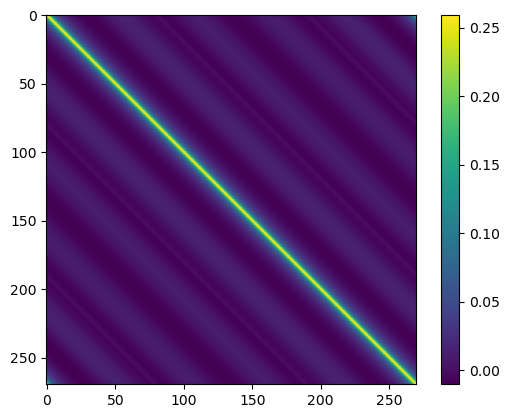

In [160]:
plt.imshow(S_fiducial)
plt.colorbar()

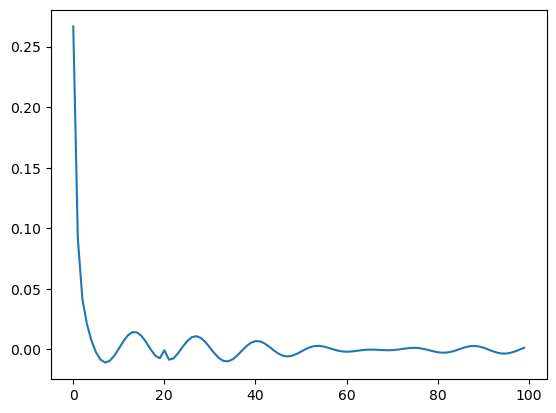

In [161]:
plt.plot(np.arange(100),xi_fid_func(np.arange(100)))

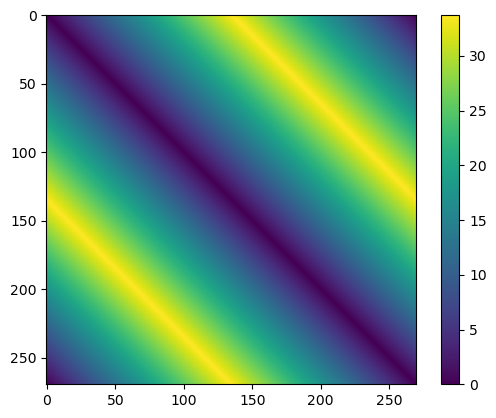

In [162]:
plt.imshow(delta_x_matrix)
plt.colorbar()

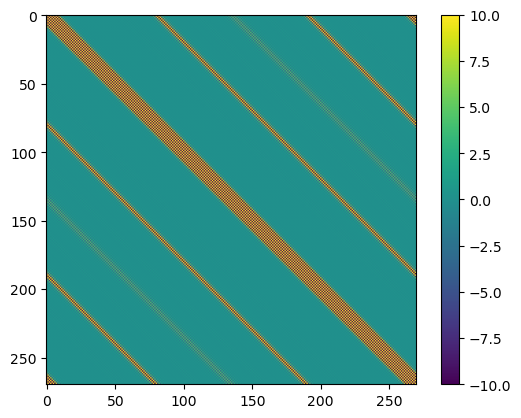

In [163]:
plt.imshow(C_0_invmat, vmin=-10,vmax=10)
plt.colorbar()

In [164]:
kbin_centers, theta_est_p1d_unmasked, F_alpha_beta_p1d_unmasked, Lalpha_P1D_unmasked = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux, kbin_est[:9], np.zeros(S_fiducial.shape), C_0_invmat, approx_fisher=True)


Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472]
Getting derivative matrices.
Starting loop through data.
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 42.82509684562683 seconds
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 79.44626760482788 seconds
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 74.16810822486877 seconds
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 68.20323085784912 seconds
0 skewers processed.
1000 s

In [25]:
kbin_centers, theta_est_p1d_masked_weighted, F_alpha_beta_p1d_masked_weighted, Lalpha_P1D_masked_weighted = est.estimate_p1d(Np, delta_x_matrix, pix_spacing, delta_flux_masked, kbin_est[:20], S_fiducial, C_0_invmat,C_0_mat=C_0_mat, weights=1/(mask+1e-5), approx_fisher=True)


Starting P1D.
center of kbins:  [0.0, 0.0930842267730309, 0.1861684535460618, 0.27925268031909267, 0.3723369070921236, 0.46542113386515443, 0.5585053606381853, 0.6515895874112162, 0.7446738141842472, 0.837758040957278, 0.9308422677303089, 1.0239264945033397, 1.1170107212763707, 1.2100949480494017, 1.3031791748224324, 1.3962634015954634, 1.4893476283684943, 1.5824318551415253, 1.675516081914556, 1.768600308687587]
Getting derivative matrices.
Starting loop through data.
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 103.81401777267456 seconds
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 112.76644229888916 seconds
0 skewers processed.
1000 skewers processed.
2000 skewers processed.
3000 skewers processed.
4000 skewers processed.
5000 skewers processed.
This k took 122.966767311

In [165]:
delta_flux_k_masked = (np.fft.fft(delta_flux_masked)).astype(np.complex64)
delta_flux_k = (np.fft.fft(delta_flux)).astype(np.complex64)

p1d_masked_fft = np.mean((delta_flux_k_masked.__abs__())**2, axis=0)
p1d_unmasked_fft = np.mean((delta_flux_k.__abs__())**2, axis=0)


In [79]:
Nbin = len(kbin_est)
p1d_fid = est.bin_model(kfine, contaminated_p1d, kbin_est, Nbin//2-2)

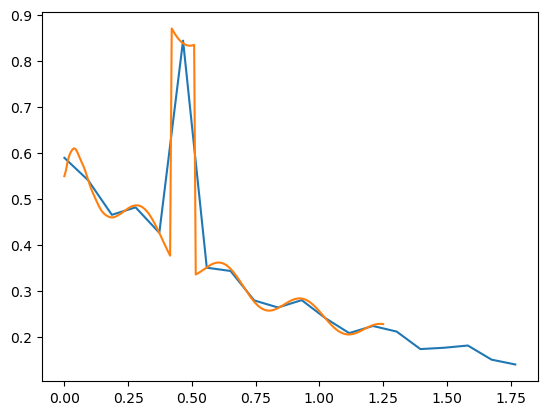

In [80]:
plt.plot(kpar[:20], p1d_fid[:20])
plt.plot(kfine[:200], contaminated_p1d[:200])

In [39]:
p1d_unmasked_fft = np.mean((delta_flux_k.__abs__())**2, axis=0)


In [40]:
mask_correction = (np.average(np.sum(mask, axis=1))/mask[0].size).real


In [41]:
mask_correction

0.9777777777777777

In [45]:
theta_est_p1d_unmasked

array([-4.57146136e-02, -1.13341370e-02,  2.61554783e-02, -4.68955631e-03,
       -1.79145108e-01, -2.05551983e-01, -1.94891098e-01,  1.92113321e-02,
        7.16290357e-03,  4.11930121e-04,  1.28513415e-02, -1.27564206e-02,
        7.15771139e-03, -1.27129683e-03,  3.58683782e-05, -4.87709479e-03,
        2.05721668e-03, -3.50670219e-03,  1.02533192e-02, -4.38732565e-03])

In [117]:
theta_est_p1d_unmasked

array([-0.09464211,  0.02342249,  0.00662949, -0.01086493, -0.0311789 ,
        0.04404712, -0.02778529,  0.0001814 ,  0.00845975])

NameError: name 'theta_est_p1d_masked_weighted' is not defined

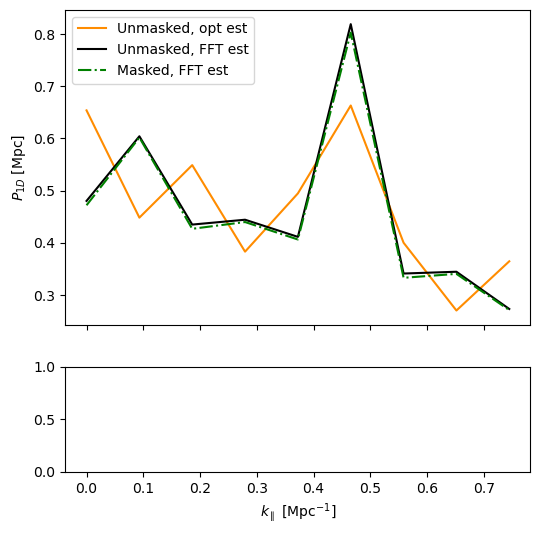

In [167]:
nmodes = 9
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
kpar_cut = kbin_centers[:nmodes]
ax[0].plot(kpar_cut, np.zeros((theta_est_p1d_unmasked[:nmodes]).shape)+theta_est_p1d_unmasked[:nmodes], label='Unmasked, opt est', color='darkorange', linestyle='solid')
# ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_masked_weighted[:nmodes], label='Masked, optimal est', linestyle='dotted', color='blue', lw=2)
ax[0].plot(kpar[:nmodes], p1d_unmasked_fft[:nmodes]*L/Np**2, label='Unmasked, FFT est', color='black', linestyle='solid')
ax[0].plot(kpar[:nmodes], p1d_masked_fft[:nmodes]/mask_correction*L/Np**2, label='Masked, FFT est', color='green', linestyle='dashdot')
# ax[0].plot(kpar[:20], p1d_fid[:20], label='first guess')
# ax[0].plot(kfine[:200], contaminated_p1d[:200]) # the model
ax[0].legend()
ax[1].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
ax[1].plot(kpar_cut, ((p1d_fid[:nmodes]+theta_est_p1d_masked_weighted[:nmodes])/(p1d_fid[:nmodes]+theta_est_p1d_unmasked[:nmodes])-1)*100, label='masked vs unmasked, opt est', color='blue')
ax[1].plot(kpar[:nmodes], ((p1d_masked_fft[:nmodes]/mask_correction)/(p1d_unmasked_fft[:nmodes])-1)*100, label='masked vs unmasked, FFT est', color='green')
ax[1].legend(loc=[.03, .6], framealpha=1)
ax[1].set_ylabel("Percentage difference")
ax[1].axhspan(-1, 1, color='grey', alpha=0.2)
ax[1].set_ylim([-5,5])
ax[1].set_xlim([0,3])
ax[0].set_title("Influence of two-line mask on optimal vs FFT estimator")

# ax[1].set_xscale('log')
# plt.savefig(f"../plots/p1d_2skymask_fft_optest.pdf", bbox_inches='tight')

plt.show()
plt.clf()


In [ ]:
nmodes = 8
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
kpar_cut = kbin_centers[:nmodes]
ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_unmasked[:nmodes], label='Unmasked, opt est', color='darkorange', linestyle='solid')
ax[0].plot(kpar_cut, p1d_fid[:nmodes]+theta_est_p1d_masked_weighted[:nmodes], label='Masked, optimal est', linestyle='dotted', color='blue', lw=2)
# ax[0].plot(kpar[:nmodes], p1d_unmasked_fft[:nmodes]*L/Np**2, label='Unmasked, FFT est', color='black', linestyle='solid')
# ax[0].plot(kpar[:nmodes], p1d_masked_fft[:nmodes]/mask_correction*L/Np**2, label='Masked, FFT est', color='green', linestyle='dashdot')

# ax[0].plot(kfine[:200], contaminated_p1d[:200]) # the model
ax[0].legend()
ax[1].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')
ax[1].plot(kpar_cut, ((p1d_fid[:nmodes]+theta_est_p1d_masked_weighted[:nmodes])/(p1d_fid[:nmodes]+theta_est_p1d_unmasked[:nmodes])-1)*100, label='masked vs unmasked, opt est', color='blue')
ax[1].plot(kpar[:nmodes], ((p1d_masked_fft[:nmodes]/mask_correction)/(p1d_unmasked_fft[:nmodes])-1)*100, label='masked vs unmasked, FFT est', color='green')
ax[1].legend(loc=[.03, .6], framealpha=1)
ax[1].set_ylabel("Percentage difference")
ax[1].axhspan(-1, 1, color='grey', alpha=0.2)
ax[1].set_ylim([-5,5])
ax[1].set_xlim([0,3])
ax[0].set_title("Influence of mask on optimal estimator")

# ax[1].set_xscale('log')
plt.savefig(f"../plots/p1d_2skymask_optest.pdf", bbox_inches='tight')

plt.show()
plt.clf()
